In [1]:
import glob
import os
os.chdir('/root/QT_NBA3')
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
#from Model.QT_PL_soft_shareV_pointer_selfattn import QT
from Model.QT_PL_0103 import QT
from pytorch_lightning.callbacks import ModelCheckpoint
import hydra
from einops import rearrange


In [3]:
file_path = '/root/autodl-fs/clean_pt/0021500413_1_1450747988260.pt'
scene = torch.load(file_path)
processed_data = scene["processed_data"]
q_mean_player = processed_data["q_player_perm_avg"] # [T,5,C]
V_ball = processed_data["V_ball"]  # [T,1]
q_ball = processed_data["q_ball_perm_avg"]#  [T,6]
done = processed_data['done']

In [4]:
# ---- inputs ----
q_ball = processed_data["q_ball_perm_avg"]          # [T,6]
q_mean_player = processed_data["q_player_perm_avg"] # [T,5,C]

# ---- actions ----
action_tokens = processed_data['action_tokens']
action_tokens_ = rearrange(action_tokens, '(b a) t -> b a t', b=1).squeeze(0)
action_tokens_[action_tokens_ == 40] = 0

action_ball = action_tokens_[0]            # [T]
action_pl   = action_tokens_[1:6]          # [5,T]
action_pl_flat = rearrange(action_pl, 'n t -> t n')  # [T,5]

# ---- Q_real ----
Q_real_ball = q_ball.gather(
    dim=1,
    index=action_ball.unsqueeze(1)
).squeeze(1)                    # [T]

Q_real_pl = q_mean_player.gather(
    dim=2,
    index=action_pl_flat.unsqueeze(-1)
).squeeze(-1)                   # [T,5]

Q_real = torch.cat(
    [Q_real_ball.unsqueeze(1), Q_real_pl],
    dim=1
)                               # [T,6]

# ---- Q_max ----
Q_max_ball = q_ball.max(dim=1).values.unsqueeze(1)   # [T,1]
Q_max_pl   = q_mean_player.max(dim=2).values         # [T,5]

Q_max = torch.cat([Q_max_ball, Q_max_pl], dim=1)     # [T,6]


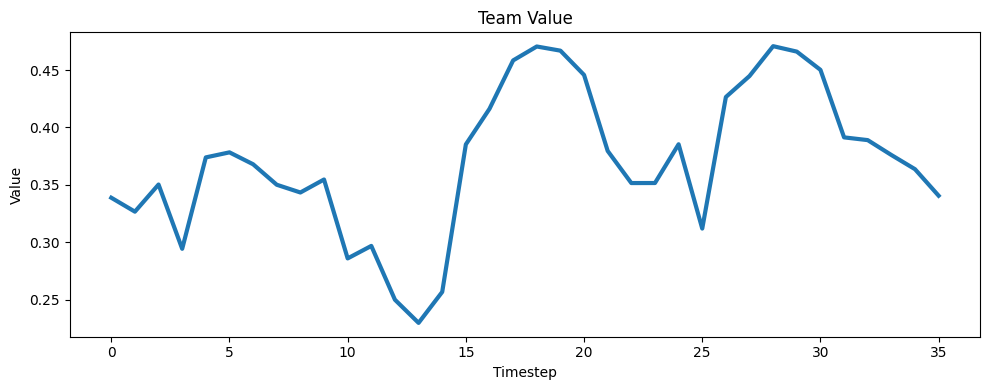

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_moving_average(x, window=5):
    return np.convolve(x, np.ones(window)/window, mode='same')
    
def plot_team_timeseries(V_ball):
    V = V_ball.squeeze(-1).numpy()      # [T]
    Show_V = V

    T = V.shape[0]

    plt.figure(figsize=(10, 4))
    plt.plot(Show_V, label="V(s)", linewidth=3)
    #plt.plot(Q_ball_gt, "--", label="Q_ball(s, a_gt)")
    #plt.plot(Q_ball_opt, ":", label="Q_ball(s, a*)")
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))


    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Team Value")
    #plt.legend()
    plt.tight_layout()
    plt.show()

os.chdir('/root/autodl-fs/')
folder_path = '/root/autodl-fs/clean_pt'
filelist = glob.glob(os.path.join(folder_path, '*.pt'))

file_path = '/root/autodl-fs/clean_pt/0021500413_1_1450747988260.pt'
scene = torch.load(file_path)
processed_data = scene["processed_data"]
V_ball = processed_data["V_ball"]
done = processed_data['done']
plot_team_timeseries(V_ball[:done])

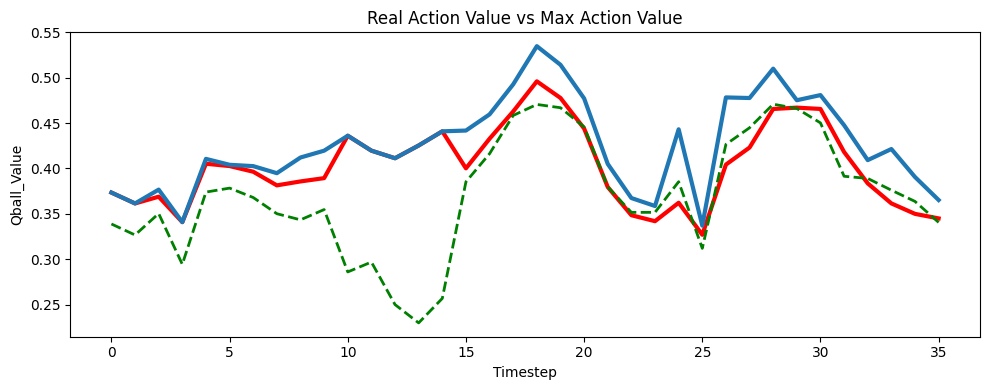

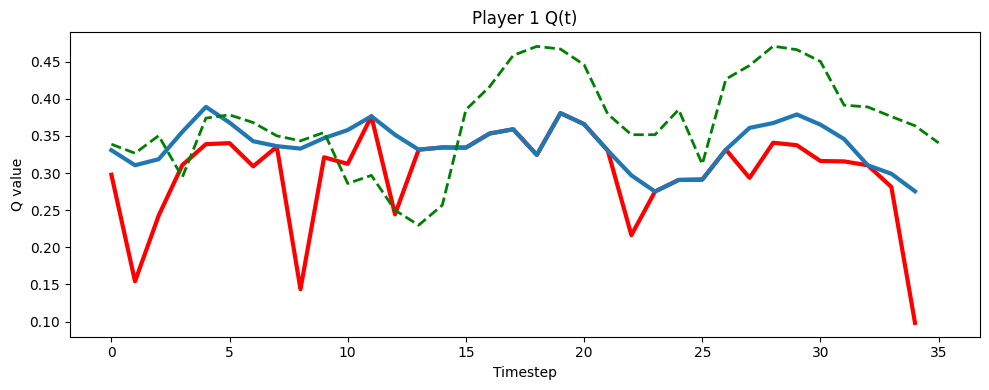

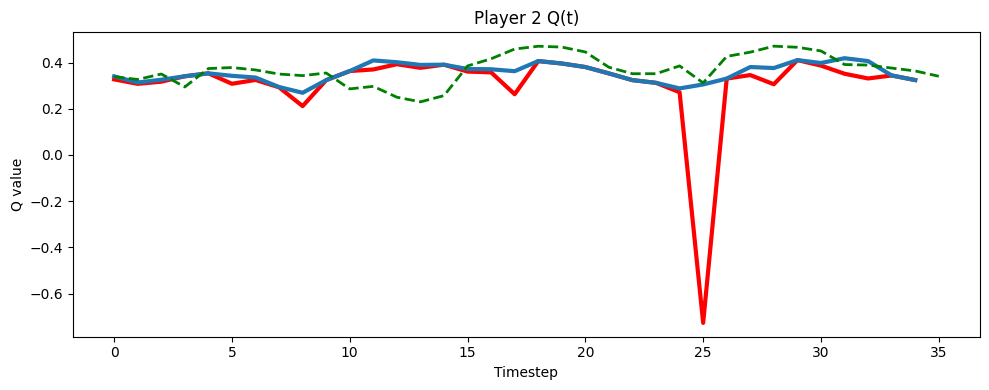

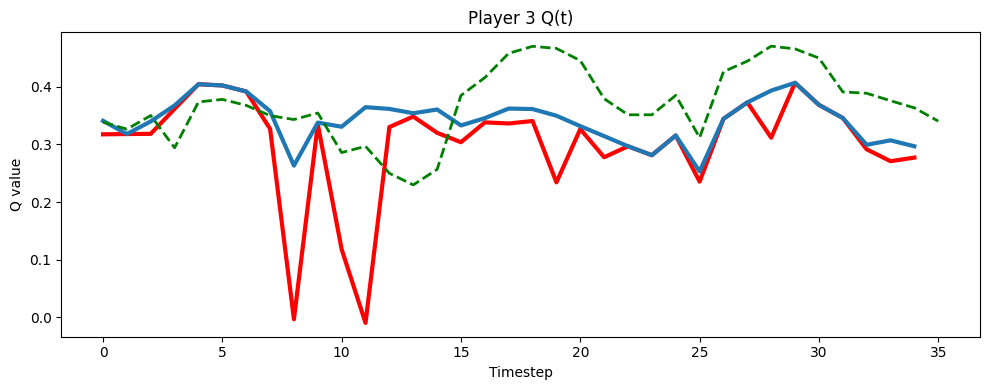

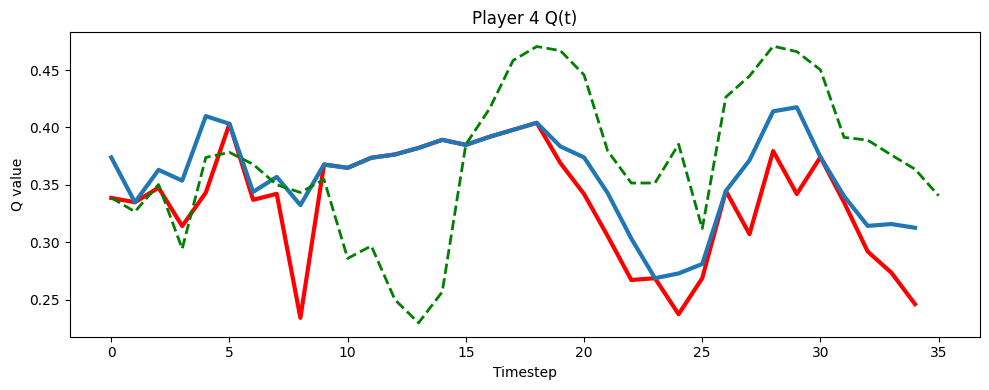

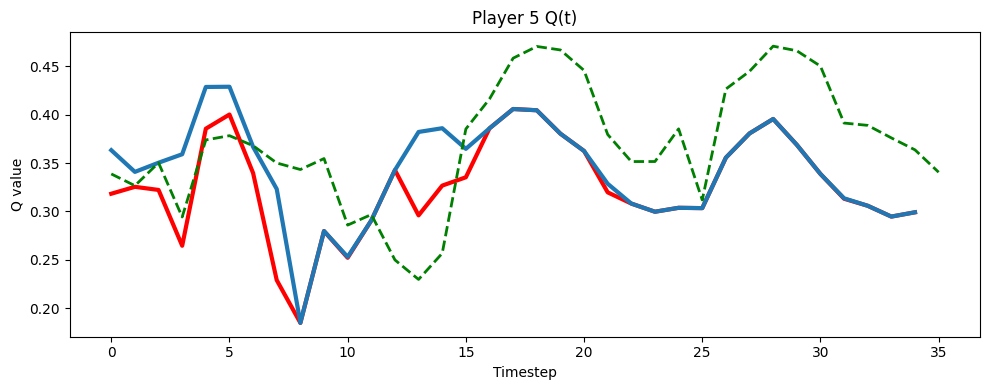

In [8]:
import matplotlib.pyplot as plt
Q_real_flat_= rearrange(Q_real[:done,:],'T a -> (T a)').numpy()      # [T]
Q_max_flat_ = rearrange(Q_max[:done,:],'T a -> (T a)').numpy() 
T = Q_real_flat_.shape[0]

V = V_ball[:done,:].squeeze(-1).numpy()      # [T]


plt.figure(figsize=(10, 4))
plt.plot(Q_real_flat_[0::6], label="Q_ball(s, a_gt)", linewidth=3,color='red')
plt.plot(Q_max_flat_[0::6], label="Q_ball(s, a*)", linewidth=3)
plt.plot(V, '--', color='green', linewidth=2, label="V(s)") 
#plt.plot(Q_ball_gt, "--", label="Q_ball(s, a_gt)")
#plt.plot(Q_ball_opt, ":", label="Q_ball(s, a*)")

plt.xlabel("Timestep")
plt.ylabel("Qball_Value")
plt.title("Real Action Value vs Max Action Value")
#plt.legend()
plt.tight_layout()
plt.show()

for i in [1,2,3,4,5]:   
    plt.figure(figsize=(10, 4))
    plt.plot(Q_real_flat_[i::6][:-1], label="Q_player(s, a_gt)", linewidth=3,color='red')
    plt.plot(Q_max_flat_[i::6][:-1], label="Q_player(s, a*)", linewidth=3)
    plt.plot(V, '--', color='green', linewidth=2, label="V(s)") 
    #plt.plot(Q_ball_gt, "--", label="Q_ball(s, a_gt)")
    #plt.plot(Q_ball_opt, ":", label="Q_ball(s, a*)")
    
    plt.xlabel("Timestep")
    plt.ylabel("Q value")
    plt.title(f"Player {i} Q(t)")
    #plt.legend()
    plt.tight_layout()
    plt.show()


In [116]:
V = V_ball.squeeze(-1)
dV = V[1:] - V[:-1]  # [T-1]

dQ = Q_real[:,:] -  Q_real[:,0:1]         # [T-1, 6], <=0



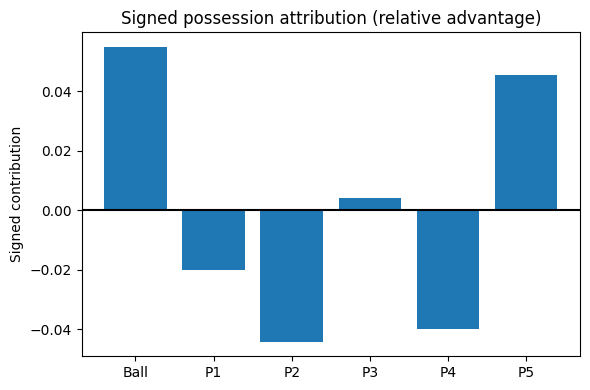

In [87]:
import torch

def contrib_attribution_signed(
    V,             # [T]         possession value
    Q_real,        # [T, N]       N=6 (ball + 5 players)
    eps=1e-8
):
    """
    Signed, conservative attribution of possession value change.

    Returns:
        contrib_signed: [T-1, N]
            Per-step attribution, can be positive or negative.
            Sum over agents equals ΔV_t.
    """

    # --------
    # 1) ΔV_t
    # --------
    dV = V[1:] - V[:-1]              # [T-1]

    # ----------------------------
    # 2) Real-action advantage
    # ----------------------------
    # A_real = Q_real - V_t
    A_real = Q_real[:-1] - V[:-1].unsqueeze(1)   # [T-1, N]

    # -------------------------------------------------
    # 3) Zero-mean across agents (relative attribution)
    # -------------------------------------------------
    A_centered = A_real - A_real.mean(dim=1, keepdim=True)  # [T-1, N]

    # ----------------------------------------
    # 4) Normalize magnitude (avoid explosion)
    # ----------------------------------------
    scale = A_centered.abs().sum(dim=1, keepdim=True) + eps
    weight = A_centered / scale                           # signed weights

    # ------------------------
    # 5) Allocate ΔV_t
    # ------------------------
    contrib_signed = weight * dV.unsqueeze(1)              # [T-1, N]

    return contrib_signed
contrib_signed = contrib_attribution_signed(
    V,             # [T]         possession value
    Q_real,        # [T, N]       N=6 (ball + 5 players)
    eps=1e-8
)

agent_names = ["Ball", "P1", "P2", "P3", "P4", "P5"]

# per-possession total
total_signed = contrib_signed.sum(dim=0).cpu()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(agent_names, total_signed)
plt.axhline(0, color="black")
plt.ylabel("Signed contribution")
plt.title("Signed possession attribution (relative advantage)")
plt.tight_layout()
plt.show()


/root/autodl-fs/clean_pt/0021500244_2_1448769730642.pt
tensor([79], device='cuda:0')
tensor([[ 0.0495, -0.0630, -0.7374,  0.0070, -0.3969,  0.1747, -0.1922,  0.0011,
          0.1913,  0.0036, -0.0013,  0.0394, -0.0808,  0.0558, -0.0171,  0.0196,
          0.3455, -0.0683, -0.6080,  0.4924,  0.7613,  0.1566,  0.0236, -0.0823,
         -0.0025, -0.1915, -0.1846,  0.0045, -0.8795, -0.1946, -0.1115, -0.0913,
         -0.0582,  0.0121,  0.4957,  0.3129, -0.4860, -0.4642, -0.3491,  0.1590,
         -0.0403,  0.1119,  0.1801,  0.9799, -0.1067,  0.5592, -0.6207, -0.1845,
         -0.3168, -0.1033, -0.1637, -0.0629,  0.0469, -0.0980, -0.0257, -0.0199,
          0.0035,  0.0738,  0.1284, -0.0099,  0.0197,  0.0386, -0.0497, -0.0689,
         -0.0163, -0.1977, -0.1376,  0.0426,  0.4761, -0.1312, -0.6857, -0.3727,
          0.0561, -0.2723, -0.0700, -0.1424,  0.0124, -0.0610, -0.7084]],
       device='cuda:0')


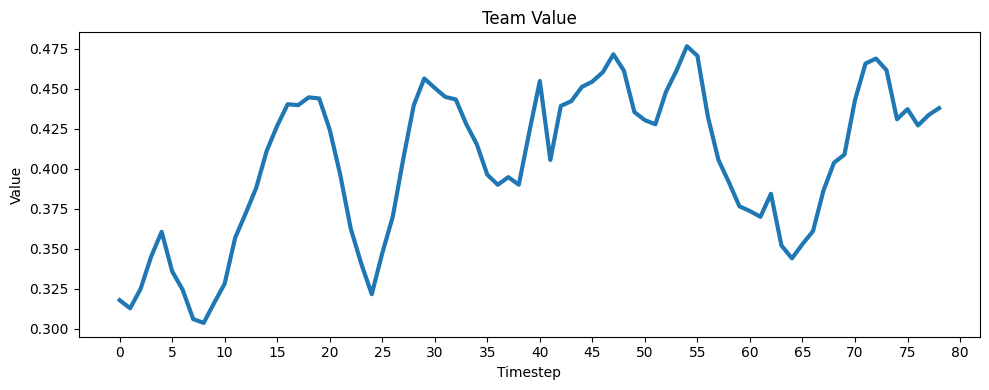

In [104]:
batch3 = next(val_iter)
print(batch3['processed_data']['id'])
episode_log1 = extract_episode_log(qt,batch3['processed_data'])
plot_team_timeseries_from_log(episode_log1)

In [75]:
q_ball_all = []      # list of [N, 6]
q_player_all = []   # list of [N, 5, C]

for file_path in filelist[:300]:
    scene = torch.load(file_path, map_location='cpu')
    pd = scene["processed_data"]

    q_ball = pd["q_ball_perm_avg"]          # [T,6]
    q_pl   = pd["q_player_perm_avg"]        # [T,5,C]
    done   = int(pd["done"])

    q_ball_all.append(q_ball[:done])
    q_player_all.append(q_pl[:done])

# concat over episodes
q_ball_all = torch.cat(q_ball_all, dim=0)        # [N_total, 6]
q_player_all = torch.cat(q_player_all, dim=0)    # [N_total, 5, C]

print("q_ball_all:", q_ball_all.shape)
print("q_player_all:", q_player_all.shape)

q_ball_all: torch.Size([13458, 6])
q_player_all: torch.Size([13458, 5, 36])


In [76]:
print("=== Ball Q distribution (across all episodes) ===")
for a in range(q_ball_all.shape[1]):
    q = q_ball_all[:, a]
    print(
        f"Ball action {a:02d}: "
        f"mean={q.mean():+.3f}, "
        f"std={q.std():.3f}, "
        f"min={q.min():+.3f}, "
        f"max={q.max():+.3f}"
    )

=== Ball Q distribution (across all episodes) ===
Ball action 00: mean=-0.149, std=0.577, min=-2.178, max=+0.682
Ball action 01: mean=+0.317, std=0.105, min=-0.165, max=+0.531
Ball action 02: mean=+0.317, std=0.103, min=-0.201, max=+0.560
Ball action 03: mean=+0.316, std=0.106, min=-0.166, max=+0.527
Ball action 04: mean=+0.321, std=0.103, min=-0.215, max=+0.530
Ball action 05: mean=+0.314, std=0.108, min=-0.198, max=+0.539


In [77]:
print("\n=== Player Q distribution (across all episodes) ===")
for pid in range(5):
    q = q_player_all[:, pid, :].reshape(-1)
    print(
        f"Player {pid+1}: "
        f"mean={q.mean():+.3f}, "
        f"std={q.std():.3f}, "
        f"min={q.min():+.3f}, "
        f"max={q.max():+.3f}"
    )


=== Player Q distribution (across all episodes) ===
Player 1: mean=-1.360, std=1.105, min=-4.152, max=+0.485
Player 2: mean=-1.370, std=1.101, min=-4.347, max=+0.462
Player 3: mean=-1.324, std=1.096, min=-4.478, max=+0.484
Player 4: mean=-1.322, std=1.089, min=-4.228, max=+0.487
Player 5: mean=-1.306, std=1.087, min=-4.194, max=+0.649


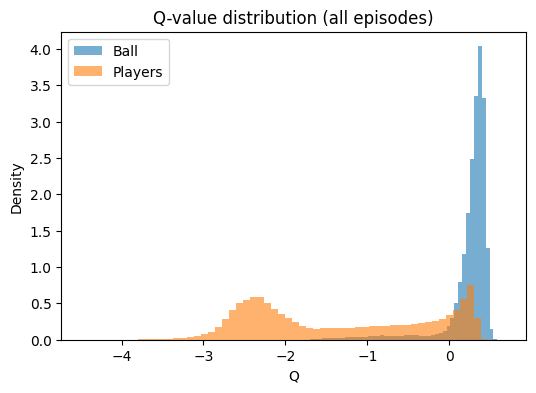

In [78]:
import matplotlib.pyplot as plt

q_ball_flat = q_ball_all.reshape(-1).numpy()
q_player_flat = q_player_all.reshape(-1).numpy()

plt.figure(figsize=(6,4))
plt.hist(q_ball_flat, bins=60, alpha=0.6, density=True, label="Ball")
plt.hist(q_player_flat, bins=60, alpha=0.6, density=True, label="Players")
plt.legend()
plt.title("Q-value distribution (all episodes)")
plt.xlabel("Q")
plt.ylabel("Density")
plt.show()

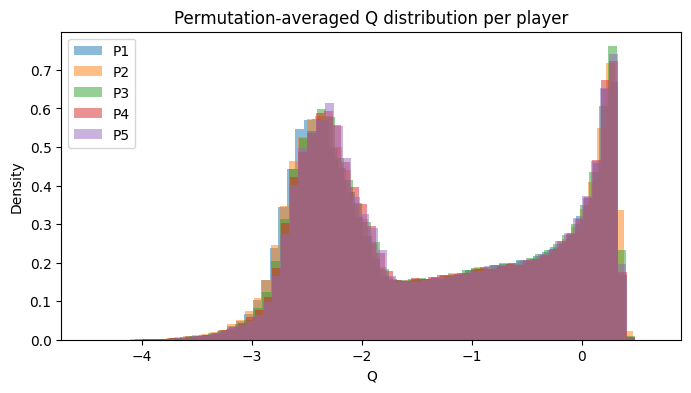

In [79]:
plt.figure(figsize=(8,4))

for pid in range(5):
    q = q_player_all[:, pid, :].reshape(-1).numpy()
    plt.hist(q, bins=60, alpha=0.5, density=True, label=f"P{pid+1}")

plt.legend()
plt.title("Permutation-averaged Q distribution per player")
plt.xlabel("Q")
plt.ylabel("Density")
plt.show()